![Melanoma Detection](https://www.yashodahealthcare.com/blogs/wp-content/uploads/2021/07/melanoma-skin-cancer.jpeg)

<cite>Image from www.yashodahealthcare.com </cite>

Problem statement: Experiment with a CNN-LSTM hybrid model that can do better in the detection of skin diseases and cancers that the existing CNN model using the same techniques provided.

### Importing all the important libraries

In [1]:
!pip install seaborn

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
import seaborn as sns

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively. Beacuse this implementation will be completed in Google Colab, the Google Drive will be mounted in this notebook.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/VT/Skin Cancer ISIC Project ECE5424')

In [5]:
data_dir_train = pathlib.Path(os.getcwd() + "/Train")
data_dir_test = pathlib.Path(os.getcwd() + "/Test")

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Check and Enable GPUs

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


In [8]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available




# Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 120
img_width = 120

Use 80% of the images for training, and 20% for validation.

## Create train_ds and val_ds

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhos

In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in d

In [12]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data


Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeD

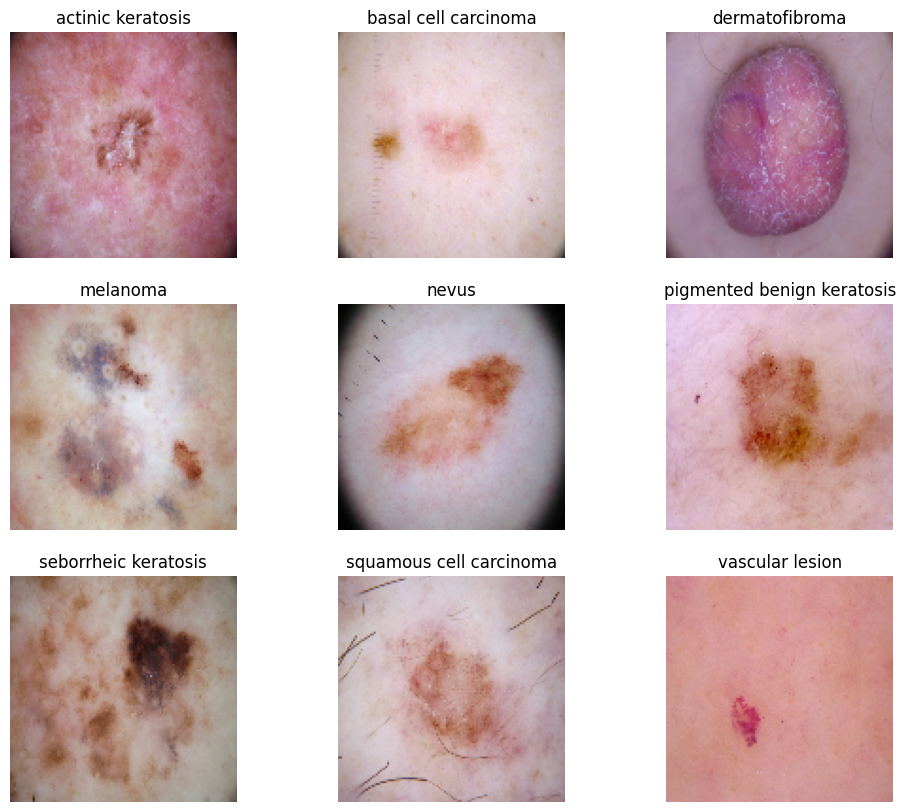

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

## Normalize the Images.

In [15]:
def normalize_image(image, label):
    #image = image.numpy().reshape(-1, 1)
    #image = scaler.transform(image)
    #image = image.reshape(img_height, img_width, 3) # Reshape back to original image shape
    #image = tf.py_function(lambda x: scaler.transform(x.numpy().reshape(-1, 1)).reshape(img_height, img_width, 3), [image], tf.float32)
    #return image, label
    return tf.image.convert_image_dtype(image, dtype=tf.float32), label

In [16]:
image_list_train_ds = []
for images, labels in train_ds:
    for image in images:
        image_list_train_ds.append(image.numpy().reshape(-1, 1))

Streaming output truncated to the last 5000 lines.
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0

# Model Implementation

## Create the model
####  A CNN-LSTM model is created to detect 9 classes present in the dataset. ```layers.experimental.preprocessing.Rescaling``` is used to normalize pixel values between (0,1) before feeding into the neural network and clean up the data.

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  #layers.Flatten(),  # Flatten after LSTM

  layers.Reshape((-1, 32)),  # Reshape to (timesteps, features) before LSTM
  layers.LSTM(32, return_sequences=True, activation = 'tanh'),
  layers.Dropout(0.2),

  layers.Flatten(),  # Flatten after LSTM
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/t

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:loca

## Compile the model
An appropirate optimiser and loss function for model training was chosen.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localh

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 450, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 450, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 450, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,928,457 (7.36 MB)

 Trainable params: 1,928,457 (7.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [20]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Streaming output truncated to the last 5000 lines.
32/56 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2520 - loss: 1.9959Executing op __inference_multi_step_on_iterator_11162 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
33/56 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2525 - loss: 1.9943Executing op __inference_multi_step_on_iterator_11162 in device /job:loc

## Visualizing training results

acc:  0.5106026530265808
val_acc:  0.5055928230285645


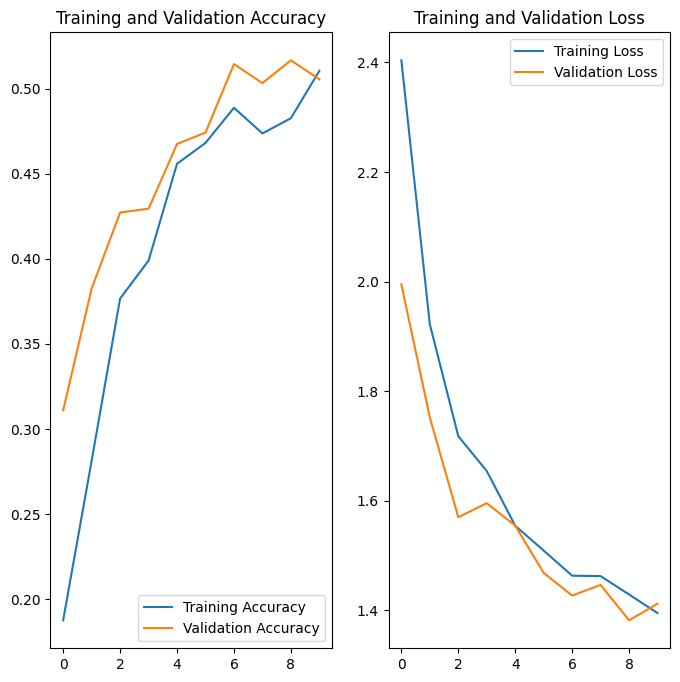

In [21]:
acc = history.history['accuracy']
print("acc: ", acc[len(acc) - 1])
val_acc = history.history['val_accuracy']
print("val_acc: ", val_acc[len(val_acc) - 1])

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:
1] We can clearly observe a drastic difference between Traning and Validation Accuracy, which indicates that the model has overfitted<br>
2] Also we can observe that the validation accuracy the model has achieved is below 55 % <br>
Overall we need to apply techniques like <b>Data Augmentation and Dropout</b> to handle the overfitting issue of the model

# Data Augmentation

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Adding Random Translation
    layers.RandomContrast(factor=0.1), # Adding Random Contrast
    layers.RandomZoom(0.1),
  ]
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localh

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localh

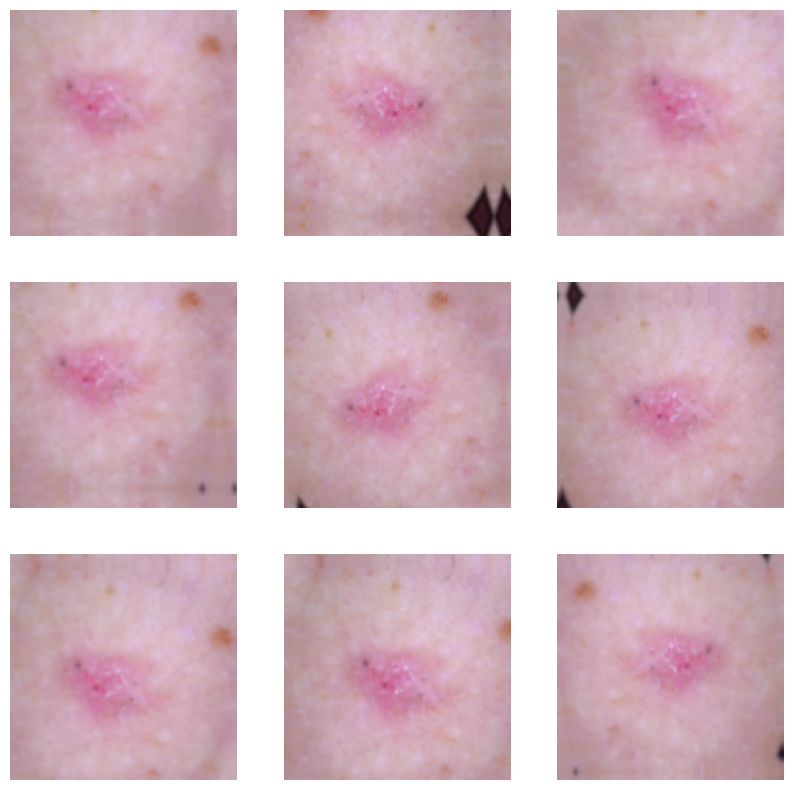

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the model, compile and train the model


In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),

  layers.Reshape((-1, 32)),  # Reshape to (timesteps, features) before LSTM
  layers.LSTM(32, return_sequences=True, activation = 'tanh'),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/t

## Compiling the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:l

## Training the model

In [26]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Streaming output truncated to the last 5000 lines.
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
32/56 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.2814 - loss: 1.9589Executing op __inference_multi_step_on_iterator_29122 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU

## Visualizing the results

acc: 0.4860491156578064
val_acc: 0.47651007771492004


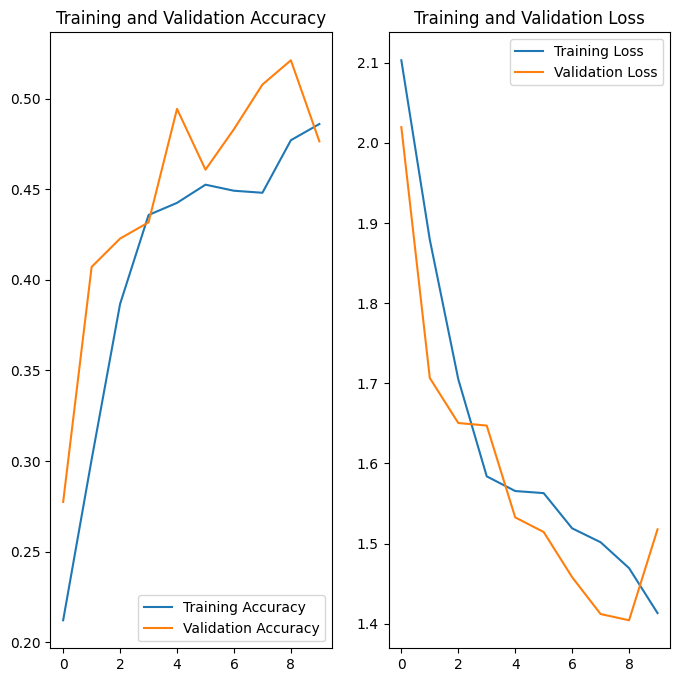

In [27]:
acc = history.history['accuracy']
print(f"acc: {acc[len(acc) - 1]}")
val_acc = history.history['val_accuracy']
print(f"val_acc: {val_acc[len(val_acc) - 1]}")

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:
As we can see that now the Training and Validation accuracy are almost in the same level and the highest accuracy achieved is around 60% , this shows the impact of how performing Data Augmentation can improve the model performance<br>
But we can still try to increase the accuracy of the model

# Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

Path              Label
0     /content/drive/My Drive/VT/Skin Cancer ISIC Pr...  actinic keratosis
1     /content/drive/My Drive/VT/Skin Cancer ISIC Pr...  actinic keratosis
2     /content/drive/My Drive/VT/Skin Cancer ISIC Pr...  actinic keratosis
3     /content/drive/My Drive/VT/Skin Cancer ISIC Pr...  actinic keratosis
4     /content/drive/My Drive/VT/Skin Cancer ISIC Pr...  actinic keratosis
...                                                 ...                ...
2234  /content/drive/My Drive/VT/Skin Cancer ISIC Pr...    vascular lesion
2235  /content/drive/My Drive/VT/Skin Cancer ISIC Pr...    vascular lesion
2236  /content/drive/My Drive/VT/Skin Cancer ISIC Pr...    vascular lesion
2237  /content/drive/My Drive/VT/Skin Cancer ISIC Pr...    vascular lesion
2238  /content/drive/My Drive/VT/Skin Cancer ISIC Pr...    vascular lesion

[2239 rows x 2 columns]

Class=0, n=114 (5.092%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=5, n=462 (20.634%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


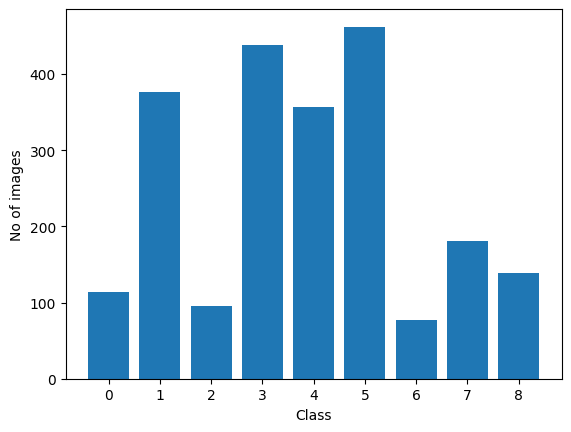

In [29]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

# Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
#     print(str(path_to_training_dataset) + "/" + i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i, output_directory = '/kaggle/working/' + i +'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA8CC52B9E0>: 100%|██████████| 500/500 [00:21<00:00, 23.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA8CE69D4C0>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA8CE046090>: 100%|██████████| 500/500 [00:19<00:00, 25.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7AA8CC7D8350>: 100%|██████████| 500/500 [01:46<00:00,  4.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7AA8E45065D0>: 100%|██████████| 500/500 [01:36<00:00,  5.17 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA8CE5E8530>: 100%|██████████| 500/500 [00:18<00:00, 27.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AA8CE5E8FE0>: 100%|██████████| 500/500 [00:45<00:00, 10.92 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA8CC5442F0>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AA8CC618740>: 100%|██████████| 500/500 [00:25<00:00, 19.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
output_dir = pathlib.Path('/kaggle/working/')

In [33]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list[:5]

['/kaggle/working/vascular lesion/output/vascular lesion_original_ISIC_0024904.jpg_cd2a04d9-8905-47b0-a482-f43cd772836c.jpg',
 '/kaggle/working/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_948b296a-7b0c-4abb-acf0-866b1187e396.jpg',
 '/kaggle/working/vascular lesion/output/vascular lesion_original_ISIC_0031759.jpg_da6ac203-fac9-402c-a85a-793f84b11f9b.jpg',
 '/kaggle/working/vascular lesion/output/vascular lesion_original_ISIC_0032240.jpg_e2e1913e-8714-49a0-a717-659a95eef83c.jpg',
 '/kaggle/working/vascular lesion/output/vascular lesion_original_ISIC_0026456.jpg_1697048f-a971-4595-a09c-15bf3295bc36.jpg']

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
lesion_list_new[:5]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion']

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df._append(df2)

In [38]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Train new balanced dataset

# Train the model on the data created using Augmentor

## Create a training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in de

Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in d

## Create your model (make sure to include normalization)

In [41]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),

  layers.Reshape((-1, 32)),  # Reshape to (timesteps, features) before LSTM
  layers.LSTM(32, return_sequences=True, activation = 'tanh'),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/t

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CP

## Compile your model (Choose optimizer and loss function appropriately)

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:l

## Train your model

In [43]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Streaming output truncated to the last 5000 lines.
31/56 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2532 - loss: 1.9623Executing op __inference_multi_step_on_iterator_44062 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:CPU:0
32/56 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2540 - loss: 1.9614Executing op __inference_multi_step_on_iterator_44062 in device /job:loc

acc: 0.5011160969734192


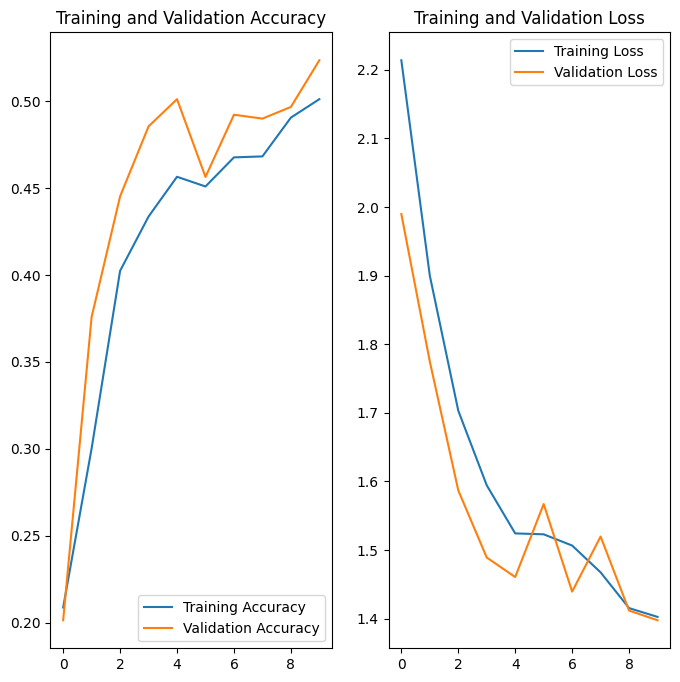

In [44]:
acc = history.history['accuracy']
print(f"acc: {acc[len(acc) - 1]}")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Findings:
We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 85%
Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting
This is a good model to be used to predict Skin Cancer using CNN

# Precision, Recall, F1 Scores, and Confusion Matrix for Balanced Dataset.

In [45]:
def calculate_f1_score_and_confusion_matrix(dataset, model, class_names):
    """Calculates the F1 score and displays the confusion matrix.

    Args:
        dataset: The dataset to evaluate.
        model: The trained model.
        class_names: List of class names.

    Returns:
        The F1 score.
    """
    y_true = []
    y_pred = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


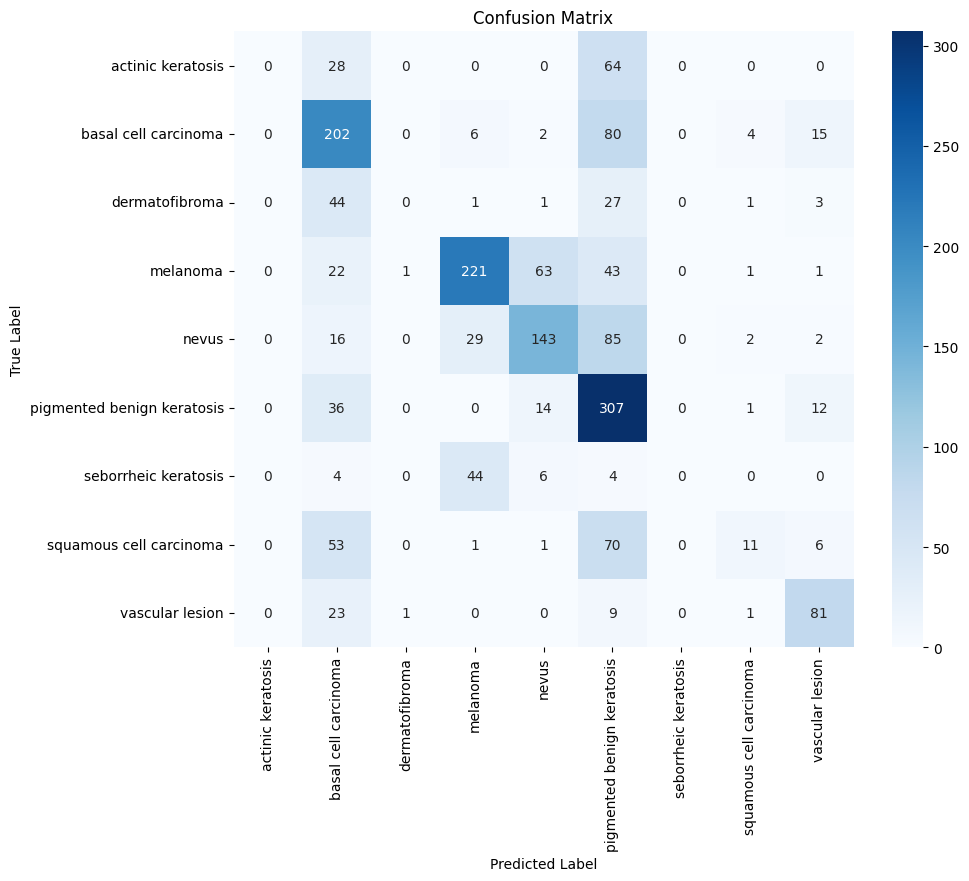

Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


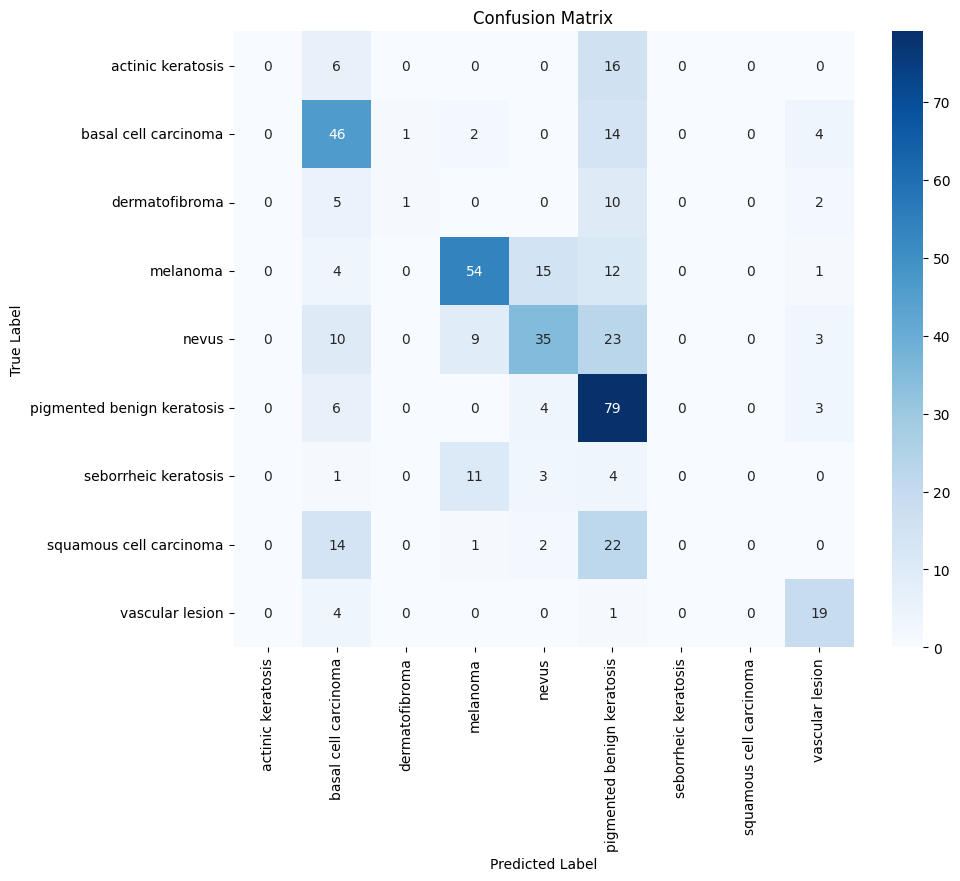

In [46]:
# Calculate F1 score and display confusion matrix
calculate_f1_score_and_confusion_matrix(train_ds, model, class_names)
calculate_f1_score_and_confusion_matrix(val_ds, model, class_names)

In [47]:
#data_augmentation = keras.Sequential(
#  [
#    layers.RandomFlip("horizontal",
#                      input_shape=(img_height,
#                                  img_width,
#                                  3)),
#    layers.RandomRotation(0.1),
#    layers.RandomZoom(0.1),

#    layers.RandomShear(height_factor=0.2, width_factor=0.2) # Example usage
#  ]
#)